In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)      # Already on by default

In [2]:
def get_num_correct(preds, labels):       # 预测正确的数量
    return preds.argmax(dim=1).eq(labels).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)     # Linear = fully connected(fc) = dense
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)                   # 卷积层中不包含激活函数，需要手动添加
        t = F.max_pool2d(t, kernel_size=2, stride=2)     # 池化操作（没有权重的函数不能称为层）
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)       # 必须手动flatten
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        # t = F.softmax(t, dim=1)           # 不直接在forward中用softmax，而是在训练过程中用cross-entropy损失函数计算loss，其中自带softmax
        
        return t
    
    
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

## Training with one batch

In [6]:
network = Network()

optimizer = optim.Adam(network.parameters(), lr=0.01)   # 优化器使用Adam

batch = next(iter(train_loader))     # 取得一个batch的数据
images, labels = batch

preds = network(images)     # Pass batch
loss = F.cross_entropy(preds, labels)   # Calculate loss

loss.backward()    # Calculate gradients
optimizer.step()   # Update weights

# ----------------------------------------------

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.308131456375122
loss2: 2.289236068725586


## Training with all batchs: A single epoch

In [7]:
network = Network()

optimizer = optim.Adam(network.parameters(), lr=0.01)   # 优化器使用Adam

total_loss = 0
total_correct = 0

for batch in train_loader:  # 通过循环得到所有batch，每层循环里就是一个batch的训练过程
    images, labels = batch   # get batch
    
    preds = network(images)  # pass batch
    loss = F.cross_entropy(preds, labels)  # calculate loss
    
    optimizer.zero_grad()    # 计算梯度之前要确保当前没有梯度值（PyTorch会自动累加计算过的梯度）
    loss.backward()     # calculate gradients
    optimizer.step()    # update weights
    
    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    
print("epoch:", 0, "total_correct:", total_correct, "loss:", total_loss)

epoch: 0 total_correct: 47034 loss: 348.50029477477074


In [8]:
total_correct / len(train_set)

0.7839

## Training with multiple epochs: The complete training loop

In [3]:
network = Network()

optimizer = optim.Adam(network.parameters(), lr=0.01)   # 优化器使用Adam

for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:  # get batch 
        images, labels = batch

        preds = network(images)  # pass batch
        loss = F.cross_entropy(preds, labels)  # calculate loss

        optimizer.zero_grad()    # 计算梯度之前要确保当前没有梯度值（PyTorch会自动累加计算过的梯度）
        loss.backward()     # calculate gradients
        optimizer.step()    # update weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)

epoch: 0 total_correct: 47233 loss: 338.15183044970036
epoch: 1 total_correct: 51757 loss: 225.80468349158764
epoch: 2 total_correct: 52330 loss: 207.80576203763485
epoch: 3 total_correct: 52687 loss: 196.08683858811855
epoch: 4 total_correct: 52933 loss: 190.50400619208813


In [10]:
total_correct / len(train_set)

0.8681

## Getting predictions for the entire training set

In [4]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:              # 按batch进行处理
        images, labels = batch        # 提取图像和标签
        
        preds = model(images)         # 得到当前batch的预测标签
        all_preds = torch.cat(        # 将每批预测标签添加进去
            (all_preds, preds),
            dim=0)
        
    return all_preds

In [5]:
with torch.no_grad():         # 关闭梯度追踪
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [6]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print("total correct:", preds_correct)
print("accuracy:", preds_correct / len(train_set))

total correct: 52316
accuracy: 0.8719333333333333


## Building a confusion matrix

In [7]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
train_preds.argmax(dim=1)

tensor([9, 0, 3,  ..., 3, 0, 5])

In [9]:
stacked = torch.stack((train_set.targets, train_preds.argmax(dim=1)),dim=1)
# 真实标签与预测标签对应元素堆叠，称为一对
stacked.shape

torch.Size([60000, 2])

In [10]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 3],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [13]:
stacked[0], stacked[0].tolist()

(tensor([9, 9]), [9, 9])

In [18]:
# 构造混淆矩阵
cmt = torch.zeros(10, 10, dtype=torch.int64)
for pair in stacked:        # 对于每对标签
    j, k = pair.tolist()    # j, k为行列
    cmt[j, k] += 1          # 对应格子的元素+1

In [19]:
cmt

tensor([[5520,    3,   84,  134,   17,    4,  162,    0,   76,    0],
        [  34, 5775,    2,  152,   19,    1,    7,    0,   10,    0],
        [ 122,    1, 4694,   80,  889,    1,  153,    0,   60,    0],
        [ 236,    6,   12, 5468,  228,    0,   33,    1,   16,    0],
        [  30,    1,  294,  179, 5336,    0,  118,    0,   42,    0],
        [   1,    0,    0,    1,    0, 5576,    0,  287,   11,  124],
        [1640,    4,  768,  132,  890,    0, 2455,    0,  111,    0],
        [   0,    0,    0,    0,    0,   16,    0, 5806,    8,  170],
        [  21,    0,    6,   22,   23,    7,   17,    7, 5894,    3],
        [   0,    0,    0,    0,    0,    9,    0,  195,    4, 5792]])

## Plotting a confusion matrix

In [26]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

In [22]:
# sklearn库中的confusion_matrix函数可以直接构建混淆矩阵，不需要手动构建
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5520,    3,   84,  134,   17,    4,  162,    0,   76,    0],
       [  34, 5775,    2,  152,   19,    1,    7,    0,   10,    0],
       [ 122,    1, 4694,   80,  889,    1,  153,    0,   60,    0],
       [ 236,    6,   12, 5468,  228,    0,   33,    1,   16,    0],
       [  30,    1,  294,  179, 5336,    0,  118,    0,   42,    0],
       [   1,    0,    0,    1,    0, 5576,    0,  287,   11,  124],
       [1640,    4,  768,  132,  890,    0, 2455,    0,  111,    0],
       [   0,    0,    0,    0,    0,   16,    0, 5806,    8,  170],
       [  21,    0,    6,   22,   23,    7,   17,    7, 5894,    3],
       [   0,    0,    0,    0,    0,    9,    0,  195,    4, 5792]],
      dtype=int64)

Confusion matrix, without normalization
[[5520    3   84  134   17    4  162    0   76    0]
 [  34 5775    2  152   19    1    7    0   10    0]
 [ 122    1 4694   80  889    1  153    0   60    0]
 [ 236    6   12 5468  228    0   33    1   16    0]
 [  30    1  294  179 5336    0  118    0   42    0]
 [   1    0    0    1    0 5576    0  287   11  124]
 [1640    4  768  132  890    0 2455    0  111    0]
 [   0    0    0    0    0   16    0 5806    8  170]
 [  21    0    6   22   23    7   17    7 5894    3]
 [   0    0    0    0    0    9    0  195    4 5792]]


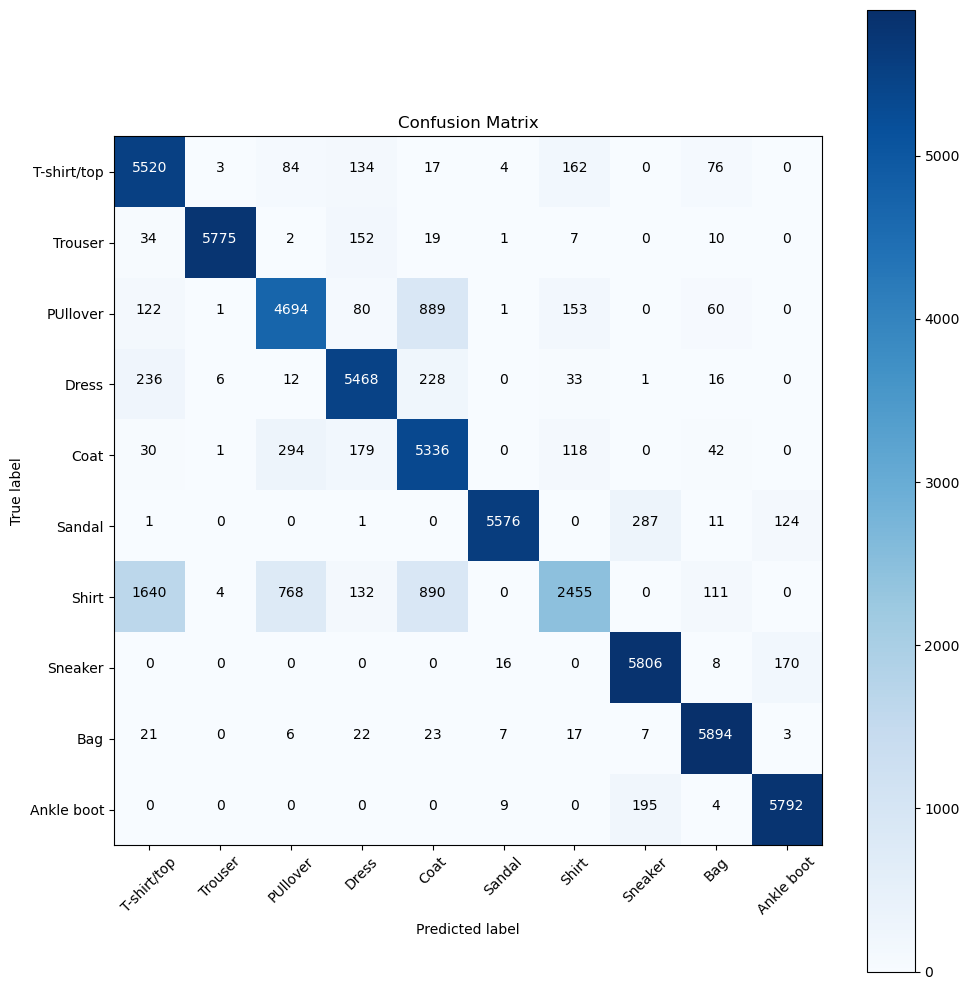

In [27]:
names = ("T-shirt/top", "Trouser", "PUllover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, names)